<a href="https://colab.research.google.com/github/ConnorSA/tutorials_ext/blob/master/DADApy_tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 2: Density estimation and cluster analysis tutorial

In this part we will deal with *densty estimation* and *density peaks estimation* (or *density-based clustering*), the tutorual is divided in two sections

1. in the first section we illustrate the algorithmic principles on a simple synthetic dataset.


2. in the second section we show how the algorithms can be used to investigate into the inner representations of neural networks, reproducing some of the results of:
    - *Hierarchical nucleation in deep neural networks*, Doimo et al., NeurIPS (2020), https://papers.nips.cc/paper/2020/file/54f3bc04830d762a3b56a789b6ff62df-Paper.pdf


## Importing and installing the required packages

In [ ]:
# import standard python packages
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style = "darkgrid")



In [ ]:
# and then install "DADApy" a package for "Distance-based Analyis of DAta-manifolds"

#!pip install git+https://github.com/sissa-data-science/dadapy.git
! pip install dadapy

     |████████████████████████████████| 191 kB 2.8 MB/s 
  Created wheel for dadapy: filename=dadapy-0.1.0-cp37-cp37m-linux_x86_64.whl size=400999 sha256=22d3ef18339564722572232e4d063346a8048e120ab79ea981d4576527c45366
  Stored in directory: /root/.cache/pip/wheels/17/3c/0b/4f0f68d808acf5fc11d7dcf17bb8e3487004065f0f65130253
Successfully built dadapy


In [ ]:
# import the main class "Data" from DADApy

from dadapy import Data


## Method illustration (synthetic data)

Text(0, 0.5, '$ \\rho (x)$')

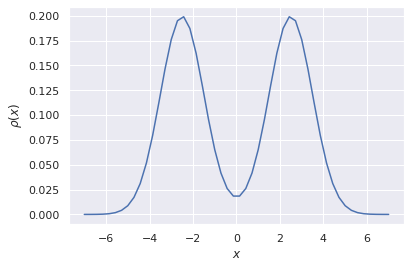

In [ ]:
# let's define a simple density as the sum of two Gaussian functions

def density(x):
    g1 = np.exp(-0.5 * (x-2.5)**2) / np.sqrt(2*np.pi)
    g2 = np.exp(-0.5 * (x+2.5)**2) / np.sqrt(2*np.pi)
    p = (g1 + g2)/2.
    
    return p

plt.figure()
x = np.linspace(-7, 7, )
plt.plot(x, density(x))

plt.xlabel(r'$x$')
plt.ylabel(r'$ \rho (x)$')


Text(0, 0.5, 'frequency')

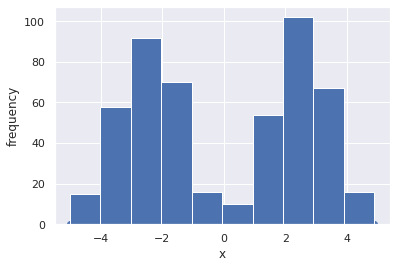

In [ ]:
# and let's sample a small dataset from the density given above

def sample(N):
    assert N<=500, 'reached the discretisation limit'
    
    xs = np.linspace(-7, 7, 5000000)
    probs = density(xs)
    probs = probs/np.sum(probs)

    np.random.seed(11)
    X = np.random.choice(xs, size=(N, 1), replace=True, p=probs)

    return X

N = 500
X = sample(N)

log_den_true = np.log(density(X))

plt.figure()
plt.scatter( X, [0]*X.shape[0] );

plt.hist(X);
plt.xlabel('x')
plt.ylabel('frequency')

In [ ]:
# to start our estimations, let's first initialise the Data class, 
# and also compute distances between points and set the intrinsic dimension

data = Data(X)

# set the number of nearest neighbour in sparse the distance matrix
data.compute_distances(maxk = X.shape[0]-1)


In [ ]:
# obviously the ID is estimated to 1 for any decimation
data.compute_id_2NN(decimation = 0.5)


(1.0759000785706636, 0.03043994406885454, 0.031556084711216945)

Text(0, 0.5, 'id')

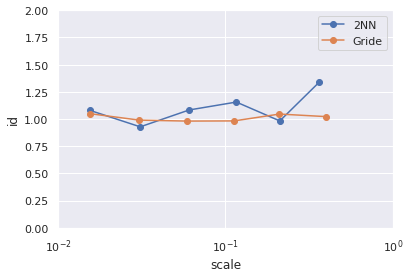

In [ ]:
# and this is appartent in a scaling analysis
ids_2nn, _, scales_2nn = data.return_id_scaling_2NN(N_min = 8)
ids_gride, _, scales_gride = data.return_id_scaling_gride(range_max = N/2)
plt.figure()
plt.plot(scales_2nn, ids_2nn, '-o', label = '2NN')
plt.plot(scales_gride, ids_gride,  '-o', label = 'Gride')
plt.xscale('log')
plt.legend()
plt.ylim(0, 2)
plt.xlim(0.01, 1.)
plt.xlabel('scale')
plt.ylabel('id')

In [ ]:
# se the id to the known one
data.set_id(1.)


### Density estimation

We can now compare different DADApy density estimators in their ability to recover the true density $\rho(x)$ from the small collected sample of size $N$.

We will compare:
- a simple *kNN* estimator, 
- an adaptive kNN estimator called *kstarNN* (where the $k^{\star}$ indicates the fact that $k$ is chosen adaptively and optimally for each point ) 
- and the Point-Adaptive-kNN or *PAk*, which improves in the *kstarNN* with an additional free parameter 

When comparing the different estimators, we will pay particular attention to their *bias* and their *variance*. We will observe the typical *bias-variance* tradeoff in the *kNN* estimator as a function of $k$, and how an *kstarNN* and *PAk* automatically find a sweet spot.

In [ ]:
# we can compute the density using several density estimators

### a simple kNN
#log_den, err = data.compute_density_kNN(k = 100)

### a simple kNN with adaptive choice of k
#log_den, err  = data.compute_density_kstarNN()

### the PAk estimator
log_den, err = data.compute_density_PAk()

/usr/local/lib/python3.7/dist-packages/dadapy/_utils/density_estimation.py:98: RuntimeWarning: divide by zero encountered in log
  1 - (r / r1) ** intrinsic_dim


Text(0, 0.5, 'predicted log_den')

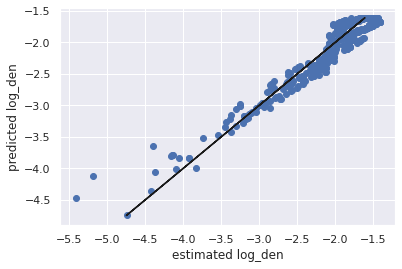

In [ ]:
# with a scatter plot of estimated vs real log density
# we can explore bias and variance of the various estimators

plt.figure()
plt.scatter(log_den, log_den_true)
plt.plot(log_den_true, log_den_true, 'k-')
plt.xlabel('estimated log_den')
plt.ylabel('predicted log_den')


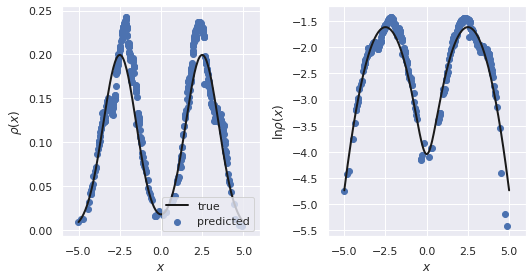

In [ ]:
# another way to visualise bias and variance is by plotting both density
# on the same graph (note that this method is only possible for 1D densities!)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (7.5, 4))
x = np.linspace(-5, 5, 200)

ax1.scatter(X, np.exp(log_den), label = 'predicted')
ax1.plot(x, density(x), label = 'true', lw = 2, color = 'k')

ax2.scatter(X, log_den)
ax2.plot(x, np.log(density(x)), lw = 2, color = 'k')


for ax in  (ax1, ax2):
    ax.set_xlabel(r'$x$')
    ax.set_xlim(-6, 6)
    
ax1.set_ylabel(r'$\rho (x)$')
ax2.set_ylabel(r'$\ln \rho (x)$')

ax1.legend()

plt.tight_layout()


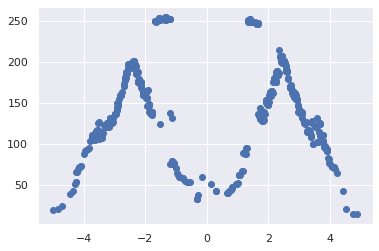

In [ ]:
# analyse the optimal k found
plt.figure()
plt.scatter(X, data.kstar)

## Density peaks estimation (density-based clustering) via ADP

In this section we explore the inner workings of the *Advanced Density Peak* (ADP) clustering.

This is an algorithm to automatically find statistically significant density peaks.

In order to work, one first need to compute the density, and wehave already seen how this can be done.

Then, the algorithm is made of two steps:

- First, the local maxima of the density are found, and all points are assigned to be peaks of the nearest local maximum

- Second, couples of density peaks are merged together if they are not both statistically significant

In [ ]:
# sample a smaller dataset, and use a suboptimal density estimator
# in order to make the density peak estimation problem less trivial

X = sample(N = 200)
data = Data(X)
data.compute_distances()
data.set_id(1.)
_ = data.compute_density_kNN(k = 25)

### Local density maxima, and initial density peak assignment

We define as cluster centers the local maxima of $\rho_i$.

We then compute $\delta_i = \min_{j : \rho_j > \rho_i} r_{ij}$, namely the distance to the nearest point with
higher $g$.

We consider point $i$ is a center if 

1) All its $k$ nearest neighbors have a value of $\rho$ lower than $\rho_i$.

$\delta_i > r_k$

2) It is not in the $k$-neighborhood of any other point with higher $\rho$.



In [ ]:

centers = data._find_density_modes(data.log_den)


Text(0, 0.5, '$\\ln \\, \\rho (x)$')

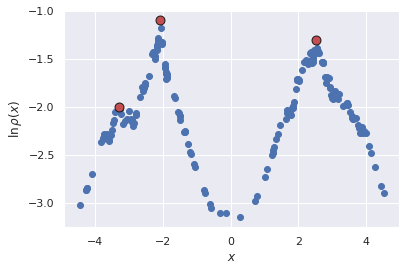

In [ ]:
# more than two peaks are found!

plt.figure()
plt.scatter(X, data.log_den)
plt.scatter(X[centers], data.log_den[centers], color = 'r', edgecolor = 'k', s = 80)

plt.xlabel(r'$x$')
plt.ylabel(r'$\ln \, \rho (x)$')

**Initial cluster assignment**

Assign all the points that are not centers to the same
cluster as the nearest point with higher $\rho$. 

This assignation is performed in order of decreasing $\rho$.

In [ ]:
# assign points to the closest density peak to form clusters

cluster_assign, cluster_struct = data._preliminary_cluster_assignment(data.log_den, centers)


Text(0, 0.5, '$\\ln \\, \\rho (x)$')

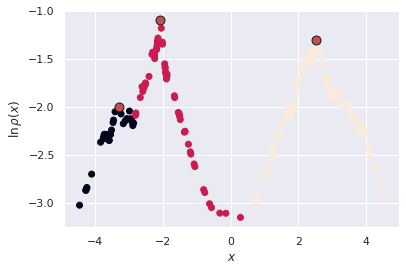

In [ ]:
# more than two clusters are found!

plt.figure()
plt.scatter(X, data.log_den, c = cluster_assign)
plt.scatter(X[centers], data.log_den[centers], color = 'r', edgecolor = 'k', s = 80,)

plt.xlabel(r'$x$')
plt.ylabel(r'$\ln \, \rho (x)$')


### Merging together statistically not-significant peaks

**Statistical significance of the density peaks**

A cluster c is considered as the result of a statistical fluctuation if all the points assigned to it have density values compatible, within their errors, with the border density. The cluster $c$ is thus merged with a neighboring cluster $c'$ if

$$(log \rho_c − log \rho_{cc'}) < Z · (\varepsilon_{c} + \varepsilon_{cc'})$$
where $\rho_c$ is the density of the center of cluster $c$.

In [ ]:
# find the saddle points between density peaks

log_den_min = np.min(data.log_den - data.log_den_err)
log_den_c = data.log_den - log_den_min + 1
g = log_den_c - data.log_den_err

log_den_bord, log_den_bord_err, bord_index = data._find_borders_between_clusters(
    Nclus = len(cluster_struct), 
    g = g, 
    cl_struct = cluster_struct, 
    centers = centers, 
    cluster_init = cluster_assign, 
    log_den_c = log_den_c)

sp_indices = list(set(list(bord_index.flatten())))
sp_indices.remove(-1)


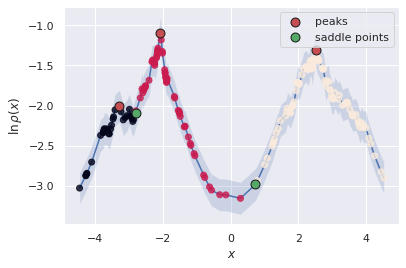

In [ ]:
# estimate the significance of the density peaks computed

xsort = np.argsort(X[:, 0])

plt.figure()
plt.plot(X[:, 0][xsort], (data.log_den)[xsort])
plt.fill_between(X[:, 0][xsort], (data.log_den - data.log_den_err)[xsort], 
                 (data.log_den + data.log_den_err)[xsort], alpha = 0.2)

plt.scatter(X, data.log_den, c = cluster_assign, alpha = 0.8, zorder = 4 )
plt.scatter(X[centers], data.log_den[centers], color = 'r', edgecolor = 'k', s = 80,
            zorder = 5, label = 'peaks')

plt.scatter(X[sp_indices], data.log_den[sp_indices], 
            color = 'g', edgecolor = 'k', s = 80, 
            zorder = 5, label = 'saddle points')


plt.xlabel(r'$x$')
plt.ylabel(r'$\ln \, \rho (x)$')
plt.legend()

In [ ]:

cluster_assign = data.compute_clustering_ADP_pure_python(Z = 1.0 )


Text(0, 0.5, '$\\ln \\, \\rho (x)$')

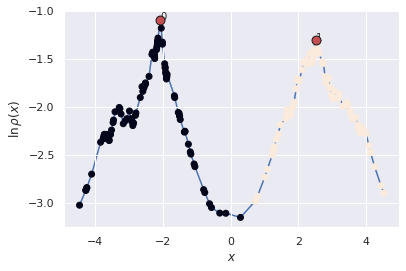

In [ ]:
# spurious density peaks are eliminated as not 
# statistically significant

plt.figure()
plt.plot(X[:, 0][xsort], (data.log_den)[xsort], zorder = 0)

plt.scatter(X, data.log_den, c = data.cluster_assignment )

for i, center in enumerate(data.cluster_centers):
    plt.scatter(X[center], data.log_den[center], color = 'r', 
            edgecolor = 'k', s = 80, zorder = 5)
    plt.annotate(str(i), (X[center], data.log_den[center]))


    
plt.xlabel(r'$x$')
plt.ylabel(r'$\ln \, \rho (x)$')

**Dendrogram analysis**



In [ ]:

from dadapy.plot import get_dendrogram


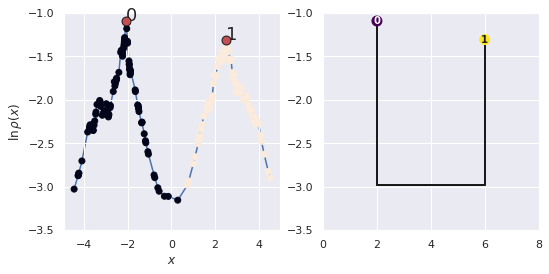

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8.5, 4))

ax1.plot(X[:, 0][xsort], (data.log_den)[xsort], zorder = 0)
ax1.scatter(X, data.log_den, c = data.cluster_assignment )

for i, center in enumerate(data.cluster_centers):
    ax1.scatter(X[center], data.log_den[center], color = 'r', 
            edgecolor = 'k', s = 80, zorder = 5)
    ax1.annotate(str(i), (X[center], data.log_den[center]), fontsize=18)

ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\ln \, \rho (x)$')

ax1.set_ylim(-3.5, -1)
ax2.set_ylim(-3.5, -1)
get_dendrogram(data)

## Density peaks of hidden neural representations

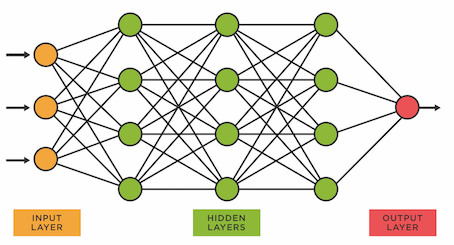

Deep convolutional networks are extremely good at classifying images. 

What kind of density profile do we expect to see in the hidden representations of such networks? Do we expect to see any further structure in the density peaks apart from the class structure?


In [ ]:
# re-download NN dustance data (if necessary)
# this dataset has 300 classes with 300 points for each class 
# (and a total of 90,000 points)

if not os.path.isdir("maxk_30"):
    from urllib.request import urlretrieve
    urlretrieve('https://ndownloader.figshare.com/files/22903688?private_link=6c875e9f4a31bfd79794', 'maxk_30.tar.gz')
    !tar -xzf maxk_30.tar.gz

# also download the macro-categories of each image (e.g., animals, artefacts)
!curl -o labels.txt https://raw.githubusercontent.com/diegodoimo/hierarchical_nucleation/master/samples_ids_and_macrolabels/macro_labels.txt
!curl -o classes.txt https://raw.githubusercontent.com/diegodoimo/hierarchical_nucleation/master/samples_ids_and_macrolabels/samples_names.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  214k  100  214k    0     0   157k      0  0:00:01  0:00:01 --:--:--  157k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  940k  100  940k    0     0   578k      0  0:00:01  0:00:01 --:--:--  578k


In [ ]:
# initialise a list of Data objects containing the distance matrices of selected layers 

checkpoints = [0, 1, 10, 34, 97, 142, 145, 148, 151, 152, 153]

data_sets = []

for cp in checkpoints:
    distances = np.load('maxk_30/layer_{}.npz'.format(cp))
    
    d = Data(distances=(distances['dist'], distances['index']), maxk = 30)
    data_sets.append(d)

macrolabels = np.genfromtxt('labels.txt')

In [ ]:
# import classes of sampled data
classes = []
with open('classes.txt', 'r') as f:
    for line in f.readlines():
    
        classes.append(line[:-1])
        
classes = np.array(classes)

In [ ]:
# compute the density of all points in all layers via a simple kNN
# more sophisticated methods can't really be used here as we have only 30 neighbours

_ = [d.compute_density_kNN(k = 30) for d in data_sets]


/usr/local/lib/python3.7/dist-packages/dadapy/id_estimation.py:160: RuntimeWarning: divide by zero encountered in true_divide
  mus = np.log(distances[:, 2] / distances[:, 1])


In [ ]:
# find statistically significant density peaks in all layers

_ = [d.compute_clustering_ADP(Z = 1.5) for d in data_sets]



In [ ]:
# number of peaks found for each layer

number_of_peaks = [d.N_clusters for d in data_sets]

print(number_of_peaks)

[5, 3, 3, 1, 4, 6, 17, 54, 128, 243, 233]


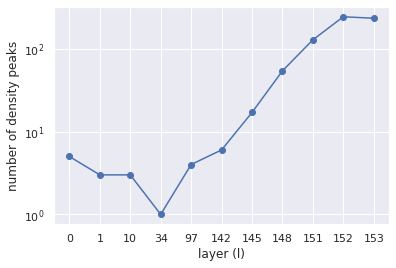

In [ ]:
# the number of peaks, first decreases, than increases again
# in the last layer, the number of peaks is roughly equal 
# to the number of classes in the sample dataset! (~300)

plt.plot(np.arange(len(number_of_peaks)), number_of_peaks, '-o')
plt.xticks(np.arange(len(number_of_peaks)), checkpoints);
plt.xlabel('layer (l)')
plt.ylabel('number of density peaks')

plt.yscale('log')

In the input representation we find only few density peaks, presumably these are related to uninformative features such as luminosity or colour.

The number of peaks first diminishes, reaching $1$ at layer $34$, and then it increases quickly towards the end of the netork in a phenomenon similar to that observed when looking at the ID profile. 

In the final layer of the network, we roughly find 1 density peak for each of the 300 categories in the dataset. This makes sense, the network has achieved is classification goal, but can be say more on what the netowrk has learned by looking at these density peaks?


In [ ]:
# To do so, we define a kernel PCA visualiser for the density peaks
# based on the difference between densities and saddle points
# of each couple of peaks

def kernel_PCA(layer):
    # obtain distance matrix from density peaks and saddle points
    distances = np.max(layer.log_den) - layer.log_den_bord
    
    distances[np.diag_indices_from(distances)] = 0.

    if distances.shape[0] < 2:
        return np.array([[0, 0]])

    else:
        # compute average distance to set lengthscae of gaussian kernel
        md = np.mean(distances[np.triu_indices_from(distances)])
        sig = np.mean(md)*1.5

        # compute kernel matrix
        ker = np.exp(- distances ** 2 / (0.5 * sig ** 2))

        # double_centering
        N = ker.shape[0]
        ker = 0.5 * (ker - 1. / N * np.sum(ker, axis=0)[None, :] 
                      - 1. / N * np.sum(ker, axis=1)[:,None]
                      + 1. / N ** 2 * np.sum(ker))

        e, v = np.linalg.eigh(ker)
        s = np.argsort(e)[::-1]
        out = v[:, s[:2]]

        return out
        

No handles with labels found to put in legend.


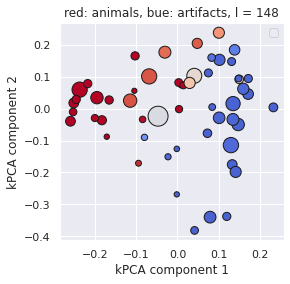

In [ ]:
# Plot 2D representation of the density peaks of a given layer

# select a specific layer
layer_idx = -4
layer = data_sets[layer_idx]

# compute 2D embedding
embedding = kernel_PCA(layer)

# Size of density peaks
s = []
for i in range(layer.N_clusters):
    s.append(3. * np.sqrt(len(layer.cluster_indices[i])))

# Color of density peaks (proportion of animals or artifacts)
# red: animals, blue: artifacts
col = []
for i in range(layer.N_clusters):
    idx = layer.cluster_indices[i]
    ancs = macrolabels[idx]
    n_animals = sum(ancs == 13)
    n_artifacts = sum(ancs == 2)

    an_frac = n_animals/(n_animals + n_artifacts) 
    
    # subtract baseline ratio between the two (unbalanced) macro classes
    an_frac = an_frac - (38400/(47100 + 38400)) + 0.5 
    
    col.append(cm.coolwarm(an_frac))

plt.figure(figsize = (4, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], 
            s = s, c = col, edgecolor = 'k')

plt.xlabel('kPCA component 1')
plt.ylabel('kPCA component 2')
plt.title('red: animals, bue: artifacts, l = {}'.format(checkpoints[layer_idx]))
plt.legend()

### Phylogenetic resemblance of density peaks structure

In [ ]:
from dadapy import plot as dplot
import copy

%matplotlib inline


In [ ]:
# copy the last layer data objext

dll = copy.deepcopy(data_sets[-1])

In [ ]:
# select only animal images from last layer, the first 38400 images of the dataset!

# find peaks populated by animals

animal_peaks = []

for i, ci in enumerate(dll.cluster_indices):
    if sum(macrolabels[ci] == 13.) > 0.5 * len(ci):
        animal_peaks.append(i)

animal_peaks = np.array(animal_peaks)
(animal_peaks == np.arange(108)).all()


True

In [ ]:
num_animals = 0
for i in range(108):
    num_animals += len(dll.cluster_indices[i])

In [ ]:
num_animals

38851

In [ ]:
# remove non-animal quantities from the object
dll.log_den = dll.log_den[:num_animals]
dll.log_den_bord = dll.log_den_bord[:108, :108]
dll.cluster_centers = dll.cluster_centers[:108]
dll.N_clusters = 108


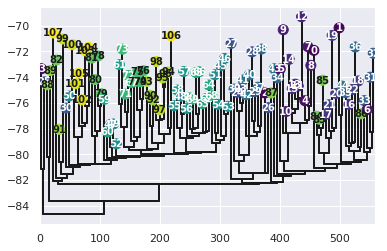

In [ ]:
dplot.get_dendrogram(dll)


In [ ]:
# butterflies! 
print(classes[dll.cluster_centers[88]])
print(classes[dll.cluster_centers[89]])

admiral
ringlet


In [ ]:
# owls! 
print(classes[dll.cluster_centers[3]])
print(classes[dll.cluster_centers[25]])

great grey owl
African grey


In [ ]:
# very hairy dogs 
print(classes[dll.cluster_centers[73]])
print(classes[dll.cluster_centers[61]])

keeshond
collie


In [ ]:
# under-water animals
print(classes[dll.cluster_centers[31]])
print(classes[dll.cluster_centers[32]])
print(classes[dll.cluster_centers[6]])
print(classes[dll.cluster_centers[33]])

sea anemone
brain coral
loggerhead
flatworm


Nicer image available in Figure 4 of:
- Hierarchical nucleation in deep neural networks, Doimo et al., NeurIPS (2020), https://papers.nips.cc/paper/2020/file/54f3bc04830d762a3b56a789b6ff62df-Paper.pdf

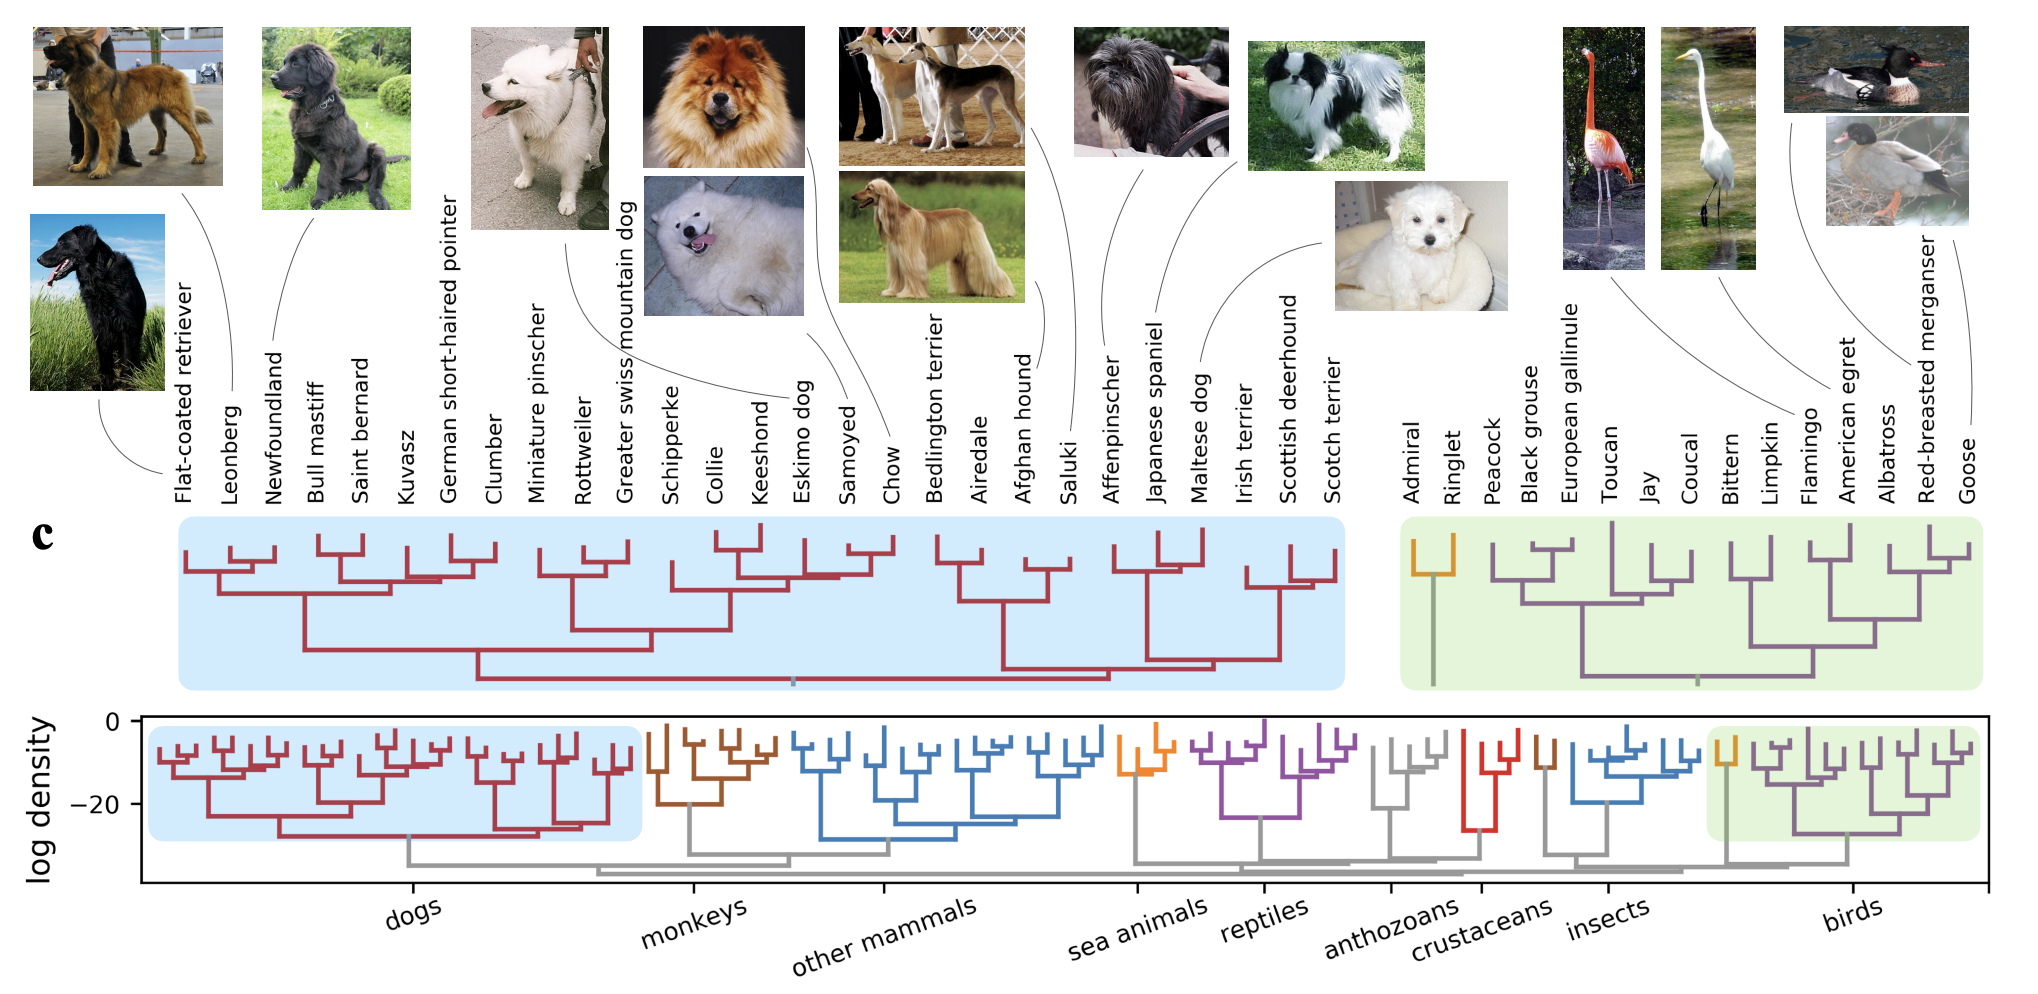

# PART 3: free exploration!